# 2023年度报告

使用em的业绩报告数据。

In [2]:
import pandas as pd
import akshare as ak
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import altair as alt
import numpy as np
from IPython.display import HTML
import sqlite3
from pathlib import Path
import datetime


In [3]:
# 解决matplotlib的中文问题
# bash中使用fc-list 找到family name
# plt.rcdefaults() # 样式调乱了，需要用它重置一下。
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
fm.fontManager.addfont(font_path)
# 设置全局字体为
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.style.use('ggplot')

In [4]:
def showProfile(df) :
    col_profile = pd.concat([df.dtypes, df.isna().sum()/len(df)*100, df.sample().T], axis=1 ).reset_index()
    col_profile.columns = ['列名', '类型', '缺失比%','样例']
    
    return (col_profile)
def fold_dataframe(df, n):
    # 确保 n 是正整数
    if n <= 0:
        raise ValueError("n 必须是正整数")
    # 添加一个新列，用于标记每一行的段号
    df = df.copy()
    m = len(df.columns)
    grey_list = [i for i in range(m, m*n+1, m+1)]
    df['id'] = [(i % n) for i in range(len(df))]
    # 使用groupby分成n组
    grouped = df.groupby('id')
    # 将每组取出来重设索引和列名
    segments = []
    for l, g in grouped:
        g = g.reset_index(drop=True)
        # 设置列格式时不支持重名的列，所以先把每组列名修改为不同
        g.columns =[f'{c}_{l}' for c in g.columns]
        segments.append(g)
    
    # 横向拼接起来
    folded_df = pd.concat(segments, axis=1)
    # folded_df = folded_df.astype('str')
    folded_df = folded_df.drop(columns=folded_df.columns[-1])
    folded_df = folded_df.replace(np.nan, '')
    # folded_df.iloc[:,grey_list] = folded_df.iloc[:,grey_list].astype('str') # 新建的列做为每组之间的分隔列
    # folded_df.iloc[:,grey_list] = ''
    def apply_color_by_position(df, cols_to_highlight):  
        '''  
        根据列位置为特定列设置红色背景色。  
        cols_to_highlight 是一个包含要设置样式的列位置的列表（从0开始计数）。  
        '''  
        # 创建一个空的DataFrame来存储样式  
        style_df = pd.DataFrame('', index=df.index, columns=df.columns)
        # 遍历要设置样式的列位置  
        for col_pos in cols_to_highlight:  
            # 注意：DataFrame.columns 返回一个Index对象，我们可以使用.iloc或.get_loc来获取位置对应的列名  
            col_name = df.columns[col_pos]  
            # 为该列的所有单元格设置背景色  
            style_df.loc[:, col_name] = 'background-color: grey; color: grey;'
        return style_df  
  
    # 调用函数并设置第2列和第3列（位置索引为1和2）的背景色为红色  
    folded_df = (folded_df.style
                 .format(precision=2)
                 .apply(apply_color_by_position, cols_to_highlight=grey_list, axis=None)
                 .relabel_index([i.split('_')[0] for i in folded_df.columns], axis=1)
                 .hide())  
    
    
    return folded_df
def plot_barh(df, title=None, fmt=None):
    # fmt = lambda x: f'{x:.2f}'
    height = len(df)*25/72+0.5
    ax = df.plot.barh(figsize=(10, height), width=0.8, legend=False, zorder=3)
    ax.bar_label(ax.containers[0], label_type='edge', fmt=fmt)
    ax.xaxis.tick_top()
    ax.xaxis.grid(True, color='#EEEEEE', zorder=0)
    ax.tick_params(left=False, bottom=False, top=False, right=False)
    title = title if title else df.columns[0]
    ax.set_title(title, fontsize=16, pad=20)
    
    plt.show(ax)
def plot_hbar(self, df, title, fmt='.2f'):
    '''
    基础hbar
    输入df必须规范化好，第一列标签是Y轴，第二列是数据X轴。
    输出为降排列的hbar
    '''

    cols=list(df.columns)
    fig = alt.Chart(df).mark_bar().encode(
    alt.X(f'{cols[1]}:Q').axis(format=fmt),
    alt.Y(f'{cols[0]}:O').sort('-x'),
    tooltip=cols
    ).properties(
        title = title,
        width = 'container',
        height = len(df)*18+80
    )
    return fig
def plot_line(df, title=''):
    ax = df.plot.line(figsize=(10, 5), title=title)
    ax.tick_params(left=False, bottom=False)
    ax.yaxis.grid(True, color = '#EEEEEE')
    return plt.show(ax)
def df_cards(df, cols=None):
    """
    把df的每一行转化为html卡片形式。
    df: 整理好的DataFrame
    cols: 要展示的列名列表，需要在调用前进行修改。确定需要展示的样式：title, big, item, content等， 如果不提供，默认使用df的列名。
    """
    if not cols:
        cols = df.columns
    df.columns = [i for i in range(len(df.columns))]
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template('cards.html')
    html_out = template.render(cols=cols, df=df)

    return HTML(html_out)
def plot_desc(df:pd.DataFrame):
    df = (df.describe().T[['mean','50%','min','max']]
          .reset_index(drop=False)
          .melt(id_vars='rdate'))

    lines = alt.Chart(df).mark_line().encode(
        x = 'rdate:O',
        y = alt.Y('value:Q').axis(format='~s'),
        color = 'variable:N'
    ).properties(width=600).interactive()
    return lines
def s_to_frame(df):
    df = df.to_frame('value').reset_index()
    df['rank'] = df.index + 1
    return df

In [29]:
class YJBB:
    def __init__(self):
        self.df = self.get_data()
        self.codedf = self.get_codes()
        self.widedf = self.tidy()
        self.longdf = self.to_long_df(self.widedf)

    def get_data(self):
        cols = ['股票代码', '股票简称', '净利润-净利润', '净利润-同比增长', '净利润-季度环比增长', 'rdate']
        cols_str = ', '.join([f'"{col}"' if '-' in col else col for col in cols])
        conn = sqlite3.connect('../yjbb.db')
        df = pd.read_sql_query(f'select {cols_str} from yjbb_data where substr(rdate, -4) = "1231"', conn)
        conn.close()
        return df
    
    def get_codes(self):
        current_time = datetime.datetime.now().timestamp()
        codes = Path('codes.csv')
        if codes.exists() :
            diff = current_time - codes.stat().st_mtime
            # print(diff)
            if diff < 3600*24:
                df = pd.read_csv(codes, dtype={'code': str})
                # print(f'{diff}s passed, read from {codes}')
                return df

        df = ak.stock_zh_a_spot_em()[['代码', '名称','市盈率-动态', '市净率', '总市值']]
        # print(df.head())
        df.columns = ['code', 'cname', 'pe', 'pb', 'mv']
        df.to_csv(codes, index=False)
        return df
        
    def tidy(self):
        """
        去除新三板的数据，去除报告有异常空值的数据。
        返回整理好的数据。行为期数，列为股票代码，值为净利润。
        """
        tdf = self.df.pivot_table(index='rdate', columns='股票简称', values='净利润-净利润', aggfunc='first')
        a_code = self.codedf['cname']
        use_code = list(set(tdf.columns) & set(a_code))
        # 去除中间有空值的代码
        tdf = tdf[use_code]
        rdate_idx = tdf.index
        tdf = tdf.reset_index(drop=True)
        first_nonull_index = list(tdf.apply(lambda col: col.first_valid_index()))
        null_counts = tdf.isnull().sum().to_list()
        mask = [False if null_counts[i] > first_nonull_index[i] else True for i in range(len(null_counts))]
        tdf = tdf[tdf.columns[mask]]
        tdf.index = rdate_idx
        # print(f'{len(use_code)} codes used, {len(tdf.columns)} left')
        
        return tdf
    def to_long_df(self, df):
        """
        整理数据，返回长格式数据。行为股票代码，列为期数，值为净利润。
        """
        return df.reset_index().melt(id_vars='rdate', var_name='code', value_name='profit').dropna()
    def bin_top300(self, col='nums'):
        df =self.widedf.T.apply(lambda col: col.nlargest(300))
        test_bin = df.T.count().sort_values(ascending=False)
        test_bin= test_bin.to_frame('nums').reset_index()
        tdf = self.widedf.count().to_frame('tnums').reset_index()
        test_bin = test_bin.merge(tdf)
        test_bin['pct'] = test_bin['nums'] / test_bin['tnums']
        bin = alt.Chart(test_bin).mark_bar().encode(
            alt.X(f'{col}:Q').bin(maxbins=14),
            y='count()',
            tooltip=['count()'],
            ).properties(width=600).interactive()
        print(f'total nums: {len(test_bin)}')
        return (bin, test_bin)
    def plot_mostn(self, n=20):
        df = self.longdf.sort_values(by=['rdate', 'profit'], ascending=False).groupby('rdate').head(n)
        df['rank'] = [i % n +1 for i in range(len(df))]
        base = alt.Chart(df).encode(
        y='rank:O',
        x=alt.Y('profit:Q').axis(format='~s'),
        text='code'
        ).properties(
            width=240,
            height=300
        )
        bars = (base.mark_bar() + base.mark_text(align='left', dx=2)).facet('rdate:O', columns=3)

        lines = alt.Chart(df).mark_line().encode(
        x='rdate:O',
        y=alt.Y('profit:Q').axis(format='~s'),
        color='code:N',
        tooltip=['code', 'profit']
        ).properties(
            width=720,
            height=480
        ).interactive()

        return (bars, lines)
    def get_mostn(self, df, n=20):
        """
        返回净利润排名前n的股票代码和名称
        """
        mostn = df.apply(lambda col: col.nlargest(n).index, axis=0)
    def incr_ana(self) -> pd.DataFrame:
        mask = (self.widedf < 0).any().values
        no_loss_df = self.widedf.iloc[:,~mask]
        loss_df = self.widedf.iloc[:,mask]
        card = {
            '从未亏损':len(no_loss_df),
            '有过亏损':len(loss_df)
        }
        most_loss = loss_df.min(axis=1)
        # 亏损次数排序
        loss_by_count = ((loss_df < 0).sum() / loss_df.count()).sort_values()
        # 亏损金额占盈利金额排序
        loss_by_value = (loss_df[loss_df < 0].sum() / loss_df[loss_df > 0].sum()).sort_values() 

        # 观察从没有亏损过的公司，因为负数无法使用对数增长率。
        log_inc = np.log(no_loss_df).diff()
        l = len(log_inc)
        ret_df = log_inc.describe().T[['count','mean','50%','min','max']]
        # keep rows more than 6 years
        ret_df = ret_df[ret_df['count'] >6]
        # 总增长幅度
        ret_df['total'] = log_inc.sum()
        # 正增长次数
        ret_df['posi_inc'] = ((log_inc > 0).sum() / log_inc.count())
        # 夏普指数
        ret_df['sharpe'] = ret_df['mean'] / log_inc.std()
        # 夏普指数近五年滚动值平均
        ss = [log_inc.iloc[:l-i,:].mean() / log_inc.iloc[: l-i, :].std() for i in range(5)]
        ret_df['sharpe_r5'] = pd.concat(ss, axis=1).T.mean()
        ret_df.reset_index(names= 'cname', inplace = True)
        ret_df = ret_df.merge(self.codedf, on='cname')
        ret_df['link'] = ret_df.apply(lambda row: f'<a href="https://data.eastmoney.com/stockdata/{row['code']}.html" target="_blank">{row["cname"]}</a>', axis=1)
        

        return ret_df
yjbb = YJBB()
widedf = yjbb.widedf
longdf = yjbb.longdf

In [6]:
test = yjbb.incr_ana()

In [7]:
test['link'] = test.apply(lambda row: f'<a href="https://data.eastmoney.com/stockdata/{row['code']}.html" target="_blank">{row["cname"]}</a>', axis=1)
df_html = test[['sharpe', 'link']].sort_values(by='sharpe', ascending=False).head(50).to_html(escape=False)


## 总利润

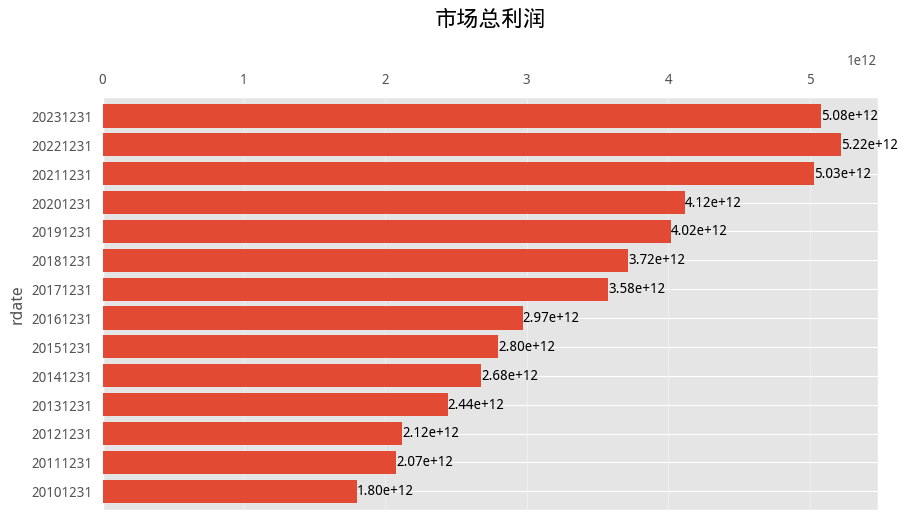

In [8]:
plot_barh(widedf.T.sum().to_frame('市场总利润'), fmt='{:.2e}')

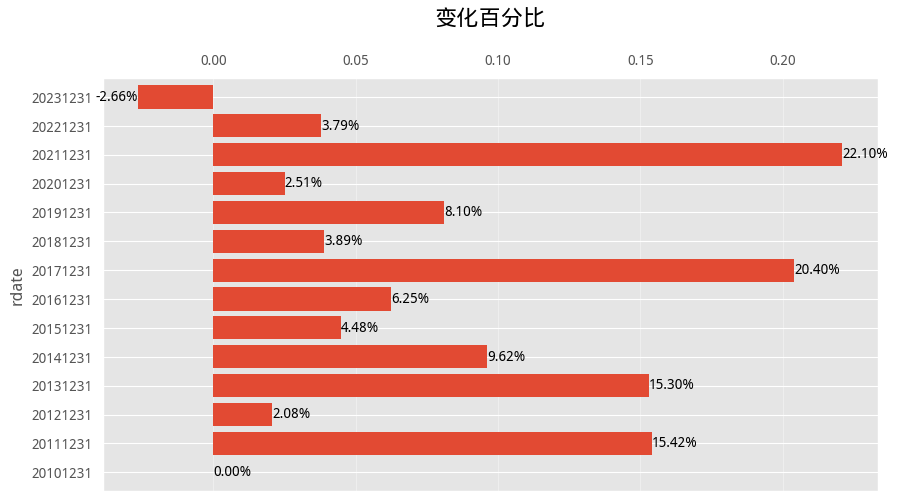

In [9]:
plot_barh(widedf.T.sum().pct_change().to_frame('变化百分比'), fmt='{:.2%}')

- 2023年可以说是历史性的一年了。A股市场总利润可能是历史上，至少是从2010年起出现的首次“负增长”。
- 过去的13年中，有4年实现两位数增长，最高的是2021年度，增长超过了21% 。
- 简单的计算总利润增长，包括了新发股票和已上市公司的利润增长两个因素。可以看一下剔除2010年后上市公司的影响，单纯看上市公司的利润增长。

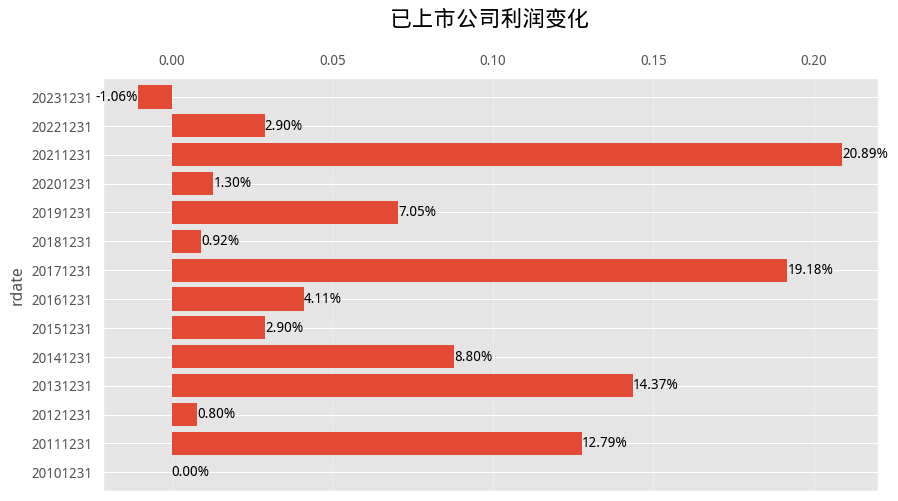

In [10]:
plot_barh(widedf.dropna(axis=1).T.sum().pct_change().to_frame('已上市公司利润变化'), fmt='{:.2%}')

可以看出，2010年后上市公司对总利润的贡献放大了利润变化的程度。老公司的衰退程度比新公司小。

In [12]:
plot_desc(widedf.T)

alt.Chart(...)

In [13]:
# pd.set_option('display.float_format', '{:.2e}'.format)

widedf.T.describe().T[['mean','50%','min','max']].style.format('{:.2e}')

,mean,50%,min,max
rdate,,,,
20101231,7.28e+08,8.38e+07,-2.64e+09,1.65e+11
20111231,6.87e+08,7.67e+07,-1.04e+10,2.08e+11
20121231,6.25e+08,6.51e+07,-9.56e+09,2.39e+11
20131231,6.34e+08,5.95e+07,-5.92e+09,2.63e+11
20141231,6.52e+08,6.07e+07,-1.62e+10,2.76e+11
20151231,6.66e+08,6.48e+07,-7.36e+09,2.77e+11
20161231,6.65e+08,8.03e+07,-1.61e+10,2.78e+11
20171231,7.47e+08,8.74e+07,-1.06e+10,2.86e+11
20181231,7.36e+08,8.62e+07,-7.15e+09,2.98e+11


## 总体变化
- 平均利润近年首次出现下滑。利润中位数出现连续第二年下滑。利润中位数小于平均数，而且有扩大的趋势，说明利润集中化。
- 利润最大的公司，都知道是工商银行，居然利润还在增长。
- 最大亏损公司，亏损金额居然是近年来亏损最少的。

In [14]:
yjbb.plot_mostn()[0]

alt.FacetChart(...)

- 所有曾上过前20榜的公司只有30家。大多数是银行。工建农中、招交邮平、兴信光浦。占了12家。
- 能源三桶油加上神华。
- 茅台，无法理解的存在。
- 中国建筑，旧时代的代表。宁德时代，新时代的代表。

In [15]:
yjbb.plot_mostn()[1]

alt.Chart(...)

- 这些大巨头中，三桶油和中国平安的波动相对较大。

## TOP300

In [16]:
top300, top300_df = yjbb.bin_top300('nums')
top300

total nums: 724


alt.Chart(...)

- 测试了一下，300是个神奇的数字。因为利润前300是变动最大的。
- 14年来共有728家上过榜。
- 其中111家是常胜将军。有165家只上过一次。

In [17]:
yjbb.bin_top300('tnums')[0]

total nums: 724


alt.Chart(...)

- 绝大多数673/728上榜公司都是2010年以前成立的。
- 只有一家公司成立仅五年就成功进入利润前300。

In [18]:
yjbb.bin_top300('pct')[0]

total nums: 724


alt.Chart(...)

- 上榜年数占报告年数的比例。
- 有122家公司在报告期每期都上榜。


In [19]:
top124 = top300_df.sort_values(['pct','nums'], ascending=False).head(124).iloc[:,[0,1]]
fold_dataframe(top124, 4)

股票简称,nums,id,股票简称,nums,id,股票简称,nums,id,股票简称,nums
渝农商行,14,0,潍柴动力,14,1,上汽集团,14,2,上海医药,14
特变电工,14,0,海天味业,14,1,海尔智家,14,2,海康威视,14
海螺水泥,14,0,泸州老窖,14,1,洋河股份,14,2,浙商银行,14
浦发银行,14,0,江苏银行,14,1,沪农商行,14,2,格力电器,14
正泰电器,14,0,民生银行,14,1,上海银行,14,2,上港集团,14
申万宏源,14,0,杭州银行,14,1,招商证券,14,2,招商银行,14
新华保险,14,0,福耀玻璃,14,1,恒瑞医药,14,2,成都银行,14
广汽集团,14,0,建发股份,14,1,建设银行,14,2,紫金矿业,14
美的集团,14,0,中国中车,14,1,中国中铁,14,2,中信建投,14
中信证券,14,0,工商银行,14,1,平安银行,14,2,广发证券,14


- 上面是top300中，近14年全部入榜，或者仅仅错失一两次的名单。
- 计算了一下，其中银行或者商行为41家，占了总数的三分之一。

In [20]:
sel = top124[~top124['股票简称'].str.contains(r'银行|商行|证券|保险')]
print(f'大金融：{124-len(sel)} | 占比：{1-len(sel)/124}')
fold_dataframe(sel, 4)


大金融：40 | 占比：0.32258064516129037


股票简称,nums,id,股票简称,nums,id,股票简称,nums,id,股票简称,nums
潍柴动力,14,0,上汽集团,14,1,上海医药,14,2,特变电工,14
海天味业,14,0,海尔智家,14,1,海康威视,14,2,海螺水泥,14
泸州老窖,14,0,洋河股份,14,1,格力电器,14,2,正泰电器,14
上港集团,14,0,申万宏源,14,1,福耀玻璃,14,2,恒瑞医药,14
广汽集团,14,0,建发股份,14,1,紫金矿业,14,2,美的集团,14
中国中车,14,0,中国中铁,14,1,中信建投,14,2,宝钢股份,14
山东高速,14,0,宁沪高速,14,1,宁波港,14,2,大秦铁路,14
复星医药,14,0,中国平安,14,1,中国建筑,14,2,中国核电,14
国泰君安,14,0,贵州茅台,14,1,双汇发展,14,2,南山铝业,14
华域汽车,14,0,中国铁建,14,1,中国交建,14,2,中国人寿,14


## 利润增长情况
- 选择了有6期以上报告的公司，测试其近5年利润增长的夏普指数平均值，从高到低排列。

In [39]:
incdf = yjbb.incr_ana()
inc300 = incdf.sort_values('sharpe_r5', ascending=False).head(300)[['link', 'sharpe_r5']].head(300)
fold_dataframe(inc300, 4)

link,sharpe,id,link,sharpe,id,link,sharpe,id,link,sharpe
心脉医疗,7.32,0,航天电器,4.90,1,老百姓,4.56,2,益丰药房,4.33
亿田智能,3.37,0,新媒股份,3.22,1,松井股份,3.17,2,恩华药业,3.16
宁波银行,3.08,0,爱尔眼科,2.95,1,志邦家居,2.93,2,协创数据,2.90
南网能源,2.79,0,江苏金租,2.61,1,中科软,2.53,2,伟明环保,2.49
海天味业,2.41,0,地铁设计,2.36,1,味知香,2.36,2,南京银行,2.33
恒盛能源,2.33,0,华翔股份,2.33,1,斯达半导,2.31,2,蜂助手,2.28
贝特瑞,2.23,0,中际联合,2.15,1,亿联网络,2.09,2,浙江鼎力,2.06
派克新材,2.05,0,普利制药,2.04,1,大博医疗,2.03,2,安图生物,2.02
华东医药,2.00,0,一心堂,1.99,1,迈克生物,1.95,2,上海银行,1.91
中熔电气,1.91,0,德源药业,1.90,1,恒瑞医药,1.89,2,金博股份,1.88


## 利润金额和利润增长
- 利润总额曾经进入过前300,同时利润增长夏普指数近五年平均也进入前300
- 大金融不管怎么排，总能占到三分之一。

In [46]:
both_win = incdf.sort_values('sharpe_r5', ascending=False).head(300).merge(top300_df, left_on='cname', right_on='股票简称', how='inner')[['link', 'count', 'sharpe_r5', 'pct']].sort_values('pct', ascending=0)
both_win_nobank = both_win[~both_win['link'].str.contains(r'银行|商行|证券')]
print(f'total: {len(both_win)} | banks: {len(both_win)-len(both_win_nobank)}')
fold_dataframe(both_win, 2)

total: 65 | banks: 23


link,count,sharpe,pct,id,link,count,sharpe,pct
宁波银行,13.00,3.08,1.00,0,南京银行,13.00,2.33,1.00
海天味业,13.00,2.41,1.00,0,恒瑞医药,13.00,1.89,1.00
上海银行,13.00,1.91,1.00,0,江苏银行,13.00,1.62,1.00
中国建筑,13.00,1.57,1.00,0,贵阳银行,13.00,1.57,1.00
海康威视,13.00,1.86,1.00,0,招商银行,13.00,1.56,1.00
沪农商行,13.00,1.36,1.00,0,重庆银行,13.00,1.38,1.00
青岛港,10.00,1.29,1.00,0,北京银行,13.00,1.26,1.00
长沙银行,13.00,1.47,1.00,0,光大银行,13.00,0.97,1.00
保利发展,13.00,0.96,1.00,0,西安银行,13.00,1.08,1.00
中国银行,13.00,1.06,1.00,0,中国外运,13.00,1.04,1.00


In [47]:
fold_dataframe(both_win_nobank, 2)

link,count,sharpe,pct,id,link,count,sharpe,pct
海天味业,13.00,2.41,1.00,0,恒瑞医药,13.00,1.89,1.00
中国建筑,13.00,1.57,1.00,0,海康威视,13.00,1.86,1.00
青岛港,10.00,1.29,1.00,0,保利发展,13.00,0.96,1.00
中国外运,13.00,1.04,1.00,0,中国中铁,13.00,1.03,1.00
海尔智家,13.00,1.00,1.00,0,中国铁建,13.00,1.01,1.00
中国平安,13.00,1.09,1.00,0,贵州茅台,13.00,1.15,1.00
上海医药,13.00,1.14,1.00,0,中国中免,13.00,1.40,0.93
公牛集团,8.00,1.00,0.89,0,大华股份,13.00,1.08,0.86
华东医药,13.00,2.00,0.64,0,立讯精密,13.00,1.52,0.64
唐山港,13.00,1.32,0.64,0,中文传媒,13.00,1.54,0.50


In [48]:
import nbformat as nbf
from pathlib import Path
def remove_input():
    fn = Path('01_listed.ipynb')
    nb = nbf.read(fn, nbf.NO_CONVERT)
    for cell in nb.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        if not 'remove_input' in cell_tags:
            cell_tags.append('remove_input')
            cell['metadata']['tags'] = cell_tags
    nbf.write(nb, fn)
remove_input()